/home/bjlazard/Rayleigh_Data/NR_project1/Shell_Slices/Shell_Slices/model_1_Shell_Avgs.dat
Version of input file was 1.
Converting current equation_coefficients instance's version to 2.
6473.413285768937
/home/bjlazard/Rayleigh_Data/NR_project1/Shell_Slices/Shell_Slices/model_2_Shell_Avgs.dat
Version of input file was 1.
Converting current equation_coefficients instance's version to 2.
8893.865306135682
/home/bjlazard/Rayleigh_Data/NR_project1/Shell_Slices/Shell_Slices/model_3_Shell_Avgs.dat
Version of input file was 1.
Converting current equation_coefficients instance's version to 2.
11662.113413767343
/home/bjlazard/Rayleigh_Data/NR_project1/Shell_Slices/Shell_Slices/model_4_Shell_Avgs.dat
Version of input file was 1.
Converting current equation_coefficients instance's version to 2.
14674.443929436056
/home/bjlazard/Rayleigh_Data/NR_project1/Shell_Slices/Shell_Slices/model_5_Shell_Avgs.dat
Version of input file was 1.
Converting current equation_coefficients instance's version to 2.
1

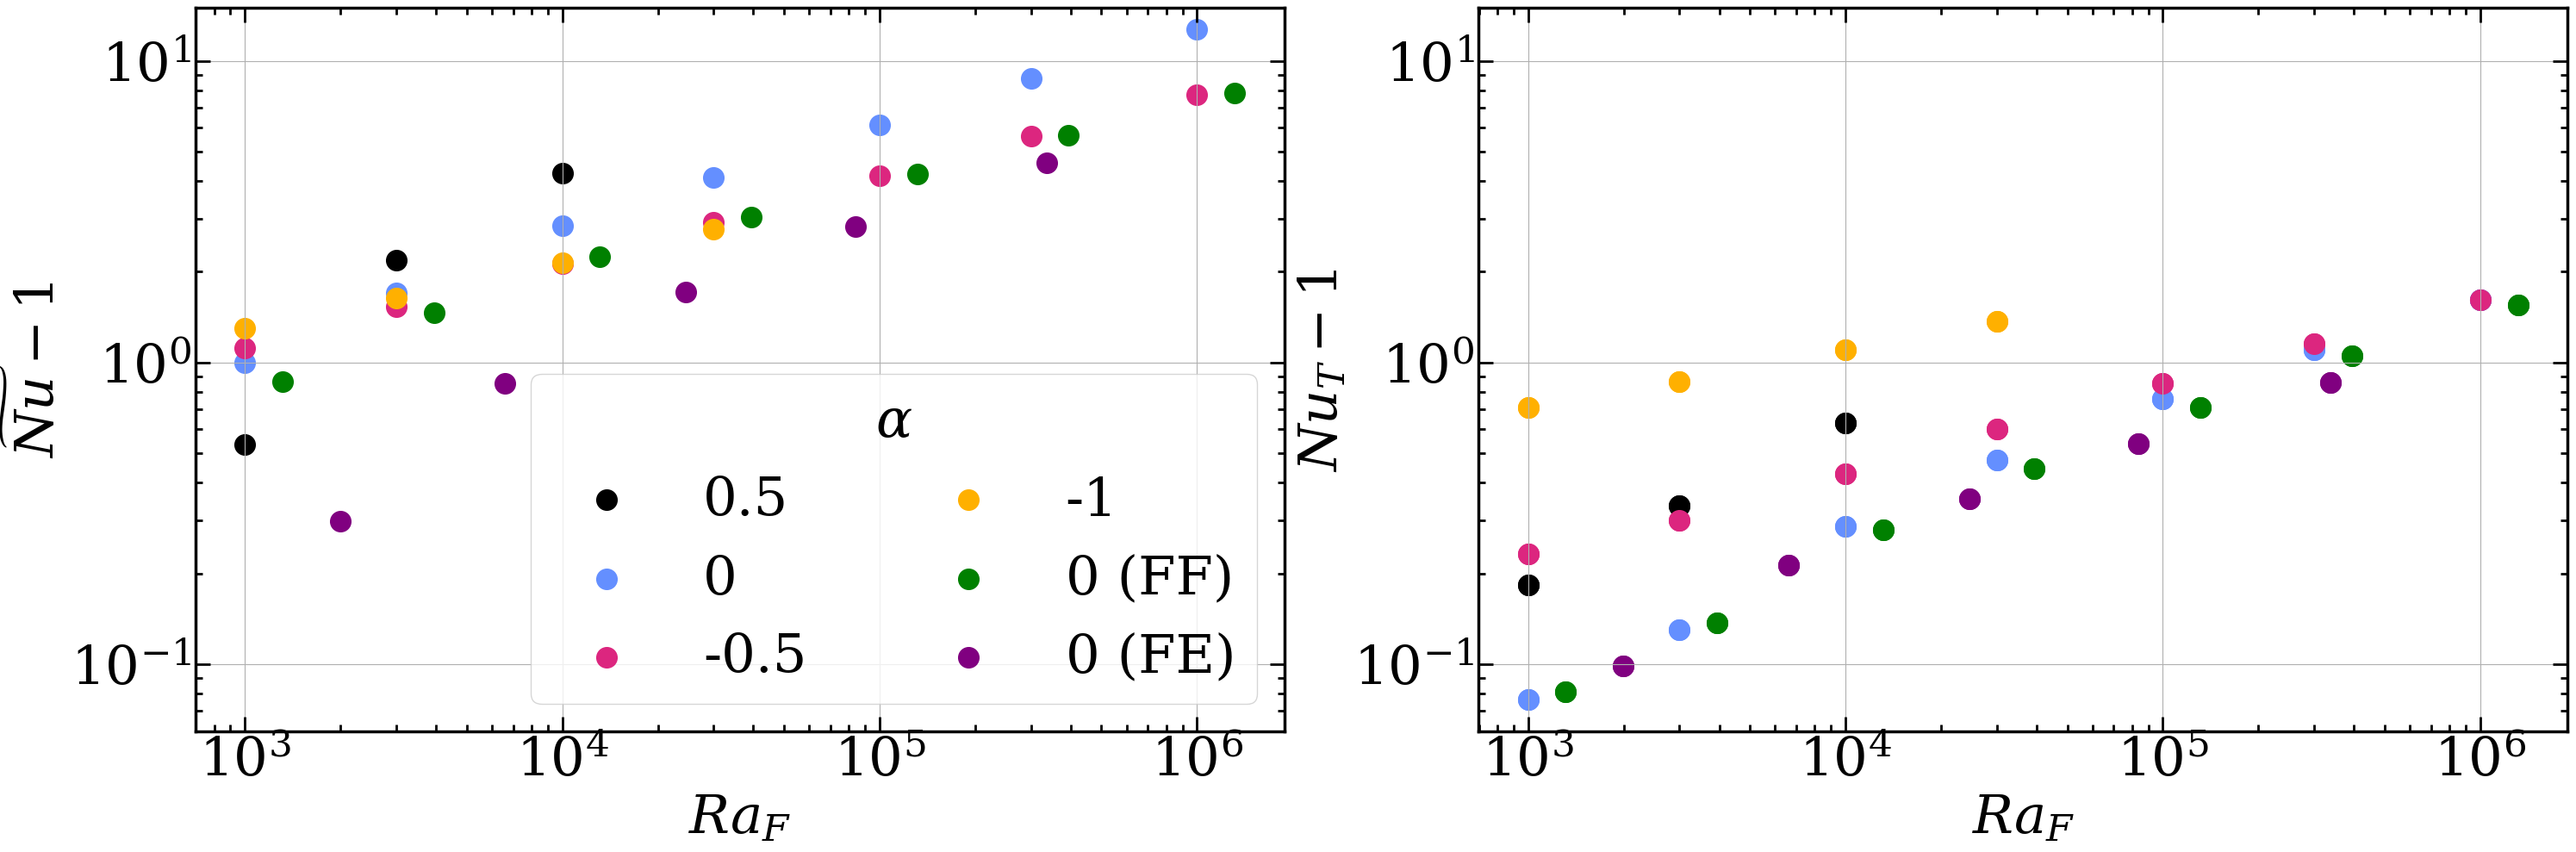

In [11]:
from rayleigh_diagnostics import G_Avgs, Shell_Slices, GridInfo
from New_Shell_Avgs import Shell_Avgs
from New_Shell_Spectra import Shell_Spectra
from reference_tools import equation_coefficients, run_int
import survey_utilities as su
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import *
import matplotlib as mpl
import spectral_utils
from scipy.optimize import curve_fit


def powerlaw(x, a, b):
    x  = a*(x**b) 
    return x


def conductive_state_flux(eqf,fixed_flux=True,delta_s = 0, luminosity=3.846e33,internal_heating=False, 
                          verbose=False):
    from reference_tools import equation_coefficients
    import numpy as np
    #  This routine calculates the conductive-state flux for either fixed-flux B.C.s, fixed-entropy B.C.s,
    #  or internally heated solutions using an equation coefficients file. 
    #  The conductive state is generally defined as the solution to:
    #          -(1/r^2)d/dr (r^2 F_c) = Q(r)

    
    
    
    #  Step 1, same for all cases.  Read in the coefficients file and grab rho, T, kappa, r, and Q(r)
    #      Since we will use Numpy's integration routines, we reverse the arrays so they are in ascending
    #      order with respect to radius (Rayleigh is normally descending order).
    
    fixed_entropy = False
    fixed_flux = not internal_heating
    if (delta_s != 0):
        fixed_flux = False
        internal_heating = False
        fixed_entropy = True
    
    eq = equation_coefficients(file=eqf)
    radius=eq.radius[::-1]
    rho = eq.functions[0][::-1]
    T = eq.functions[3][::-1]
    kappa = eq.constants[5]*eq.functions[4][::-1]
    Q = eq.constants[9]*eq.functions[5][::-1] 
    nr = eq.nr
    
    pi = np.pi
    fpr = 4*pi*radius*radius
    # Case 1:
    # Note that we will use luminosity from the argument/parameter instead of from 
    # the equation coefficients file since the main_input dSdr is what is used by
    # Rayleigh for the B.C.s and this could differ from the value of luminosity set,
    # which would be ignored
    if (fixed_flux):
        L = luminosity
        F_c = L/fpr
        dSdr_c = -F_c/(rho*T*kappa)
        S_c = run_int(dSdr_c/(fpr),radius)  # NOTE:  run_int computes integral of 4 pi r^2 times the first parameter
        S_c = S_c - S_c[nr-1]  # set S = 0 at the top
        Q[:] = 0
        msg = 'Fixed Flux'
            
    # Fixed entropy is straightforward on paper, but it looks a little odd 
    # when coded up due to the  constants of integration.
    # We have that dS/dr = A/(r^2 rho T kappa)  and 
    # S = A integral A/(r^2 rho T kappa) dr + B
    if (fixed_entropy):
        integrand = 1/(radius*radius*rho*T*kappa)
        integral = run_int(integrand/fpr,radius) #AGAIN, see NOTE above
        # There are two integration constants to set, so two adjustments to make
        
        #First, set the scale factor so that the entropy contrast is correct
        # (i.e., we set A)
        delta_s_current = integral[0]-integral[nr-1]
        amp = delta_s/delta_s_current
        integral = integral*amp
        
        #Next, set S = 0 at the top (so we set B)
        integral = integral - integral[nr-1]

        print(integral[0]-integral[nr-1])
        S_c = integral
        dSdr_c = amp/(radius*radius*rho*T*kappa)
        F_c = -amp/radius/radius
        Q[:] = 0
        msg = 'Fixed Entropy'
    # Finally, the internally-heated case
    # We have that:  r^2 rho T kappa dS/dr = -int(r^2 Q) + A
    # Let f(r) = int(r^2 Q), then dS/dr = 1/(r^2 rho T kapp)*(f(r)+A)
    # We want dsdr(r_bottom) = 0, so A = -f(r_bottom)
    if (internal_heating):
        integrand = -radius*radius*Q
        f = run_int(integrand/fpr,radius)
        f = f - f[0]  # set dsdr = 0 at the bottom
        dSdr_c = f/(rho*T*kappa*radius*radius)
        F_c = f/(radius*radius)
        S_c = run_int(dSdr_c/fpr,radius)
        S_c = S_c - S_c[nr-1]  # set S = 0 at the top
        msg = 'Internal Heating'
    
    if (verbose):
        print(msg)
    return (S_c, dSdr_c, F_c, Q, radius)


#Flux rayleigh numbers for the models   
Raf_mod1 = [1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6]
Raf_mod2 = [1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6]
Raf_mod3 = [1e3, 3e3, 1e4, 3e4]
Raf_modff = [1.314e3, 3.94e3, 1.314e4, 3.94e4, 1.314e5, 3.94e5, 1.314e6]
Raf_mod4 = [1e3, 3e3, 1e4]
Raf_modfx = [1992.5982679097528, 6602.7635701334075, 24548.79834765906, 83775.0504486985, 337035.47201444005]


#Set up the figure
fig, ax = plt.subplots(1, 2, figsize = (30, 10))
plt.setp(ax[0].spines.values(), linewidth=2.5)
plt.setp(ax[1].spines.values(), linewidth=2.5)
#plt.setp(ax[2].spines.values(), linewidth=2.5)
#plt.setp(ax[1].spines.values(), linewidth=2)
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

#1-7 is alpha = 0 , 8-14 is alpha = -0.5, 15-18 is alpha = -1, 1f-7f is fixed flux without internal heating, 24-27 is alpha = 0.5, and 1fx-7fx is fixed entropy models
file = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '1f', '2f', '3f', '4f', '5f', '6f', '7f', '24', '23', '22', '3fx', '4fx', '5fx', '6fx', '7fx']

Nu_1_volav = []
Nu_2_volav = []
Nu_3_volav = []
Nu_4_volav = []
Nu_fx_volav = []
Nu_ff_volav = []

Nu_1_flux = []
Nu_2_flux = []
Nu_3_flux = []
Nu_4_flux = []
Nu_fx_flux = []
Nu_ff_flux = []

Nu_1_diff = []
Nu_2_diff = []
Nu_3_diff = []
Nu_4_diff = []
Nu_fx_diff = []
Nu_ff_diff = []


#Loop through the models to calculate Nusselt numbers
for i in range(1, 34):
    #Read in shell avgs file
    prefix = '/home/bjlazard/Rayleigh_Data/NR_project1/Shell_Slices/Shell_Slices/model_'
    suffix = '_Shell_Avgs.dat'
    infile = prefix + file[i-1] + suffix
    sa = Shell_Avgs(infile, path = '')
    gi = GridInfo()  # This reads the grid_info file

    #Specify file path for equation coefficients
    prefix1 = '/home/bjlazard/Rayleigh_Data/NR_project1/eq_coeff/eq_'
    infile1 = prefix1 + file[i-1]


    #Read in entropy 
    entropy = sa.lut[501]
    S = sa.vals[:, 0, entropy]
    ds = float(np.max(S) - np.min(S))

    #Read in conductive flux
    cflux = sa.vals[:,0,sa.lut[1470],0]
    Fc_top = cflux[0] 

    #Calculate the other Fluxes
    eflux = sa.vals[:,0,sa.lut[1455],0]  # enthalpy flux
    kflux = sa.vals[:,0,sa.lut[1923],0]  # kinetic energy flux
    vflux = -sa.vals[:,0,sa.lut[1935],0] # viscous flux

    #calculate the total flux
    tflux = eflux+cflux+kflux+vflux # total flux. This is not constant because we are not including radiative flux in our calculation
    fpr = 4*np.pi*sa.radius**2

    #Calculate the Nu number as vol_avg(total flux)/vol_avg(conductive flux)
    flux_no_cond = eflux+vflux+kflux  
    num = np.sum(gi.rweights*tflux)
    denom = np.sum(gi.rweights*cflux)
    Nu_vol_avg = num/denom

    #values needed for later
    radius = sa.radius
    pi = np.pi
    fpr = 4*pi*radius**2


    #Calculate the flux in the conductive state
    fe = conductive_state_flux(infile1, delta_s = ds)
    F_cstate = fe[2]

    #Calculate the Nusselt number as the ratio of the conductive flux out the top of the simulation to the flux in a purely conducting state
    Nu_flux = Fc_top / F_cstate[-1]

    #calulate the percent difference
    Nu_diff = (np.abs(((Nu_vol_avg-1) - (Nu_flux-1))) / (Nu_flux-1))*(100)
    
    #Calculate Nu numbers for each model and append to the appropriate list
    if i <= 7:
        Nu_1_volav.append(Nu_vol_avg-1)
        Nu_1_flux.append(Nu_flux-1)
        Nu_1_diff.append(Nu_diff)
    elif (i >= 8) and (i < 15):
        Nu_2_volav.append(Nu_vol_avg-1)
        Nu_2_flux.append(Nu_flux-1)
        Nu_2_diff.append(Nu_diff)
    elif (i >= 15) and (i <= 18):
        Nu_3_volav.append(Nu_vol_avg-1)
        Nu_3_flux.append(Nu_flux-1)
        Nu_3_diff.append(Nu_diff)
    elif (i >= 19) and (i <= 25):  
        Nu_ff_volav.append(Nu_vol_avg-1)
        Nu_ff_flux.append(Nu_flux-1)
        Nu_ff_diff.append(Nu_diff)
    elif (i >= 26) and (i <= 28):
        Nu_4_volav.append(Nu_vol_avg-1)
        Nu_4_flux.append(Nu_flux-1)
        Nu_4_diff.append(Nu_diff)
    else:
        Nu_fx_volav.append(Nu_vol_avg-1)
        Nu_fx_flux.append(Nu_flux-1)
        Nu_fx_diff.append(Nu_diff)


####################### FITTING ##############################################
popt1_volav, pcov1_volav = curve_fit(powerlaw, Raf_mod1[2:], Nu_1_volav[2:])
popt2_volav, pcov2_volav = curve_fit(powerlaw, Raf_mod2[2:], Nu_2_volav[2:])
popt3_volav, pcov3_volav = curve_fit(powerlaw, Raf_mod3, Nu_3_volav)
popt4_volav, pcov4_volav = curve_fit(powerlaw, Raf_mod4, Nu_4_volav)
popt5_volav, pcov5_volav = curve_fit(powerlaw, Raf_modff[2:], Nu_ff_volav[2:])
popt6_volav, pcov6_volav = curve_fit(powerlaw, Raf_modfx[2:], Nu_fx_volav[2:])


label1_volav = fr'$Nu-1 \sim {popt1_volav[0]:.3f}~\times~Ra_F^{{{popt1_volav[1]:.3f}}}$'
label2_volav = fr'$Nu-1 \sim {popt2_volav[0]:.3f}~\times~Ra_F^{{{popt2_volav[1]:.3f}}}$'
label3_volav = fr'$Nu-1 \sim {popt3_volav[0]:.3f}~\times~Ra_F^{{{popt3_volav[1]:.3f}}}$'
label4_volav = fr'$Nu-1 \sim {popt4_volav[0]:.3f}~\times~Ra_F^{{{popt4_volav[1]:.3f}}}$'
label5_volav = fr'$Nu-1 \sim {popt5_volav[0]:.3f}~\times~Ra_F^{{{popt5_volav[1]:.3f}}}$'
label6_volav = fr'$Nu-1 \sim {popt6_volav[0]:.3f}~\times~Ra_F^{{{popt6_volav[1]:.3f}}}$'


popt1_flux, pcov1_flux = curve_fit(powerlaw, Raf_mod1[2:], Nu_1_flux[2:])
popt2_flux, pcov2_flux = curve_fit(powerlaw, Raf_mod2[2:], Nu_2_flux[2:])
popt3_flux, pcov3_flux = curve_fit(powerlaw, Raf_mod3, Nu_3_flux)
popt4_flux, pcov4_flux = curve_fit(powerlaw, Raf_mod4, Nu_4_flux)
popt5_flux, pcov5_flux = curve_fit(powerlaw, Raf_modff[2:], Nu_ff_flux[2:])
popt6_flux, pcov6_flux = curve_fit(powerlaw, Raf_modfx[2:], Nu_fx_flux[2:])


label1_flux = fr'$Nu-1 \sim {popt1_flux[0]:.3f}~\times~Ra_F^{{{popt1_flux[1]:.3f}}}$'
label2_flux = fr'$Nu-1 \sim {popt2_flux[0]:.3f}~\times~Ra_F^{{{popt2_flux[1]:.3f}}}$'
label3_flux = fr'$Nu-1 \sim {popt3_flux[0]:.3f}~\times~Ra_F^{{{popt3_flux[1]:.3f}}}$'
label4_flux = fr'$Nu-1 \sim {popt4_flux[0]:.3f}~\times~Ra_F^{{{popt4_flux[1]:.3f}}}$'
label5_flux = fr'$Nu-1 \sim {popt5_flux[0]:.3f}~\times~Ra_F^{{{popt5_flux[1]:.3f}}}$'
label6_flux = fr'$Nu-1 \sim {popt6_flux[0]:.3f}~\times~Ra_F^{{{popt6_flux[1]:.3f}}}$'


#################### Plot Everything ###########################################
marker_size = 290
# --- Plotting on the first subplot (ax[0]) ---
ax[0].scatter(Raf_mod4, Nu_4_volav, marker='o', s=marker_size, color='black', zorder=1)
ax[0].scatter(Raf_mod1, Nu_1_volav, marker='o', s=marker_size, color='#648FFF', zorder=1)
ax[0].scatter(Raf_mod2, Nu_2_volav, marker='o', s=marker_size, color='#DC267F', zorder=1)
ax[0].scatter(Raf_mod3, Nu_3_volav, marker='o', s=marker_size, color='#FFB000', zorder=1)
ax[0].scatter(Raf_modff, Nu_ff_volav, marker='o', s=marker_size, color='green', zorder=1)
ax[0].scatter(Raf_modfx, Nu_fx_volav, marker='o', s=marker_size, color='purple', zorder=1)

# --- Plotting on the second subplot (ax[1]) ---
# Add labels here to automatically create the legend later
ax[1].scatter(Raf_mod4, Nu_4_flux, marker='o', s=marker_size, color='black', zorder=1, label=r'0.5')
ax[1].scatter(Raf_mod1, Nu_1_flux, marker='o', s=marker_size, color='#648FFF', zorder=1, label=r'0')
ax[1].scatter(Raf_mod2, Nu_2_flux, marker='o', s=marker_size, color='#DC267F', zorder=1, label=r'-0.5')
ax[1].scatter(Raf_mod3, Nu_3_flux, marker='o', s=marker_size, color='#FFB000', zorder=1, label=r'-1')
ax[1].scatter(Raf_modff, Nu_ff_flux, marker='o', s=marker_size, color='green', zorder=1, label=r'0 (FF)')
ax[1].scatter(Raf_modfx, Nu_fx_flux, marker='o', s=marker_size, color='purple', zorder=1, label=r'0 (FE)')

l5 = ax[1].scatter(Raf_mod4, Nu_4_flux, marker = 'o', s=marker_size,color = 'black', zorder = 1, label = r'0.5')
l1 = ax[1].scatter(Raf_mod1, Nu_1_flux, marker = 'o', s=marker_size,color = '#648FFF', zorder = 1, label = r'0')
l2 = ax[1].scatter(Raf_mod2, Nu_2_flux, marker = 'o', s=marker_size,color = '#DC267F', zorder = 1, label = r'-0.5')
l3 = ax[1].scatter(Raf_mod3, Nu_3_flux, marker = 'o', s=marker_size,color = '#FFB000', zorder = 1, label = r'-1')
l4 = ax[1].scatter(Raf_modff, Nu_ff_flux, marker = 'o', s=marker_size,color = 'green', zorder = 1, label = r'0 (FF)')
l6 = ax[1].scatter(Raf_modfx, Nu_fx_flux, marker = 'o', s=marker_size,color = 'purple', zorder = 1, label = r'0 (FE)')
l0 = ax[1].scatter(10000, 1, color = 'none', label = ' ')

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel(r'$Ra_F$', fontsize = 45)
ax[0].set_ylabel(r'$\widetilde{Nu}-1$', fontsize = 45)
ax[0].set_ylim(0.06, 15)
ax[0].grid()

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$Ra_F$', fontsize = 45)
ax[1].set_ylabel(r'$Nu_{T}-1$', fontsize = 45)
ax[1].set_ylim(0.06, 15)
ax[1].grid()

legend1 = ax[0].legend(ncol =2, title = r'$\alpha$', title_fontsize = 45, handles = [l5, l1, l2, l3, l4, l6], loc = 'lower right', fontsize = 45)

#legend1 = ax[2].legend(handles = [u0[0], u4, u1, u2, u3, u5, u6], bbox_to_anchor = (0, -0.75), loc = 'lower left', fontsize = 25, framealpha = 1)
#legend2 = ax[1].legend(handles = [f5, f1, f2, f3, f4, f6], bbox_to_anchor = (0, -0.70), loc = 'lower left', fontsize = 25, framealpha = 1)
#legend3 = ax[0].legend(handles = [v5, v1, v2, v3, v4, v6], bbox_to_anchor = (0, -0.70), loc = 'lower left', fontsize = 25, framealpha = 1)


ax[0].tick_params(which='minor', top = True, direction = 'in', length = 6, width = 2, right = True, labelsize = 45)
ax[0].tick_params(which='major', top = True, direction = 'in', length = 12, width = 2, right = True, labelsize = 45)
ax[1].tick_params(which='minor', top = True, direction = 'in', length = 6, width = 2, right = True, labelsize = 45)
ax[1].tick_params(which='major', top = True, direction = 'in', length = 12, width = 2, right = True, labelsize = 45)
#ax[2].tick_params(which='minor', top = True, direction = 'in', length = 6, width = 2, right = True, labelsize = 24)
#ax[2].tick_params(which='major', top = True, direction = 'in', length = 12, width = 2, right = True, labelsize = 24)
plt.tight_layout()
plt.savefig('Nu_vs_RaF_comparison.pdf', bbox_inches = 'tight', dpi = 200)
